In [1]:
!pip install tensorflow==2.15
!pip install qutip==4.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
import os
import sys
import csv
import math
import time
import re
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras import backend as K
#from keras.layers.preprocessing import preprocessing_utils

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/sdes')
import sde_solve
import sde_systems
import data_gen

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/systems')
import rabi_weak_meas

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/models')
import fusion
import flex
import train

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/models/test')
import test_fusion

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [5]:
import imp
imp.reload(fusion)
imp.reload(flex)
imp.reload(train)
imp.reload(sde_systems)
imp.reload(data_gen)
imp.reload(sde_solve)
imp.reload(test_fusion)

<module 'test_fusion' from '/content/gdrive/MyDrive/git/quantumML/python/models/test/test_fusion.py'>

In [6]:
tf.__version__

'2.15.0'

In [7]:
import qutip as qt

# Run and test RNN vs. Liouv. vs. R2D vs. QuTip

In [8]:
sx0 = qt.tensor(qt.sigmax(), qt.identity(2))
sx1 = qt.tensor(qt.identity(2), qt.sigmax())
sy0 = qt.tensor(qt.sigmay(), qt.identity(2))
sy1 = qt.tensor(qt.identity(2), qt.sigmay())
sz0 = qt.tensor(qt.sigmaz(), qt.identity(2))
sz1 = qt.tensor(qt.identity(2), qt.sigmaz())
sm0 = qt.tensor(qt.sigmam(), qt.identity(2))
sm1 = qt.tensor(qt.identity(2), qt.sigmam())

qtmeas0 = [sx0, sy0, sz0]
qtmeas1 = [sx1, sy1, sz1]

sxx = qt.tensor(qt.sigmax(), qt.sigmax())
sxy = qt.tensor(qt.sigmax(), qt.sigmay())
sxz = qt.tensor(qt.sigmax(), qt.sigmaz())

syx = qt.tensor(qt.sigmay(), qt.sigmax())
syy = qt.tensor(qt.sigmay(), qt.sigmay())
syz = qt.tensor(qt.sigmay(), qt.sigmaz())

szx = qt.tensor(qt.sigmaz(), qt.sigmax())
szy = qt.tensor(qt.sigmaz(), qt.sigmay())
szz = qt.tensor(qt.sigmaz(), qt.sigmaz())

xup = (1.0/np.sqrt(2.0))*(qt.basis(2,0) + qt.basis(2,1))
yup = (1.0/np.sqrt(2.0))*(qt.basis(2,0) + 1j*qt.basis(2,1))
psi0 = qt.tensor(xup, yup)
qtrho0 = psi0*psi0.dag()

#qtopt = qt.Options()
#qtopt.method = 'euler-maruyama'

In [9]:
num_traj = 1
mint = 0.0
maxt = 4.0
deltat = 2**(-8)
tvec = np.arange(mint, maxt, deltat)

kappa = 4.0*0.83156
eta = 0.1469
gamma_s = 0.0
omegas = [1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 2.0, 2.0, 2.0]
epsilons = [0.0, 0.5, 1.0, 0.0, 0.5, 1.0, 0.0, 0.5, 1.0]
num_eps = len(epsilons)
params = np.array([0.0,2.0*kappa,eta,gamma_s,0.0], dtype=np.double)

sx, sy, _ = sde_systems.paulis()
rho0 = sde_systems.get_init_rho(sx, sy, 0, 0)

# Make the RNN layer
lstm_size = 10
a_rnn_cell_real = tf.keras.layers.LSTMCell(lstm_size, kernel_initializer='zeros', recurrent_initializer='zeros', bias_initializer='zeros')
a_rnn_cell_imag = tf.keras.layers.LSTMCell(lstm_size, kernel_initializer='zeros', recurrent_initializer='zeros', bias_initializer='zeros')
b_rnn_cell_real = tf.keras.layers.LSTMCell(lstm_size, kernel_initializer='zeros', recurrent_initializer='zeros', bias_initializer='zeros')
b_rnn_cell_imag = tf.keras.layers.LSTMCell(lstm_size, kernel_initializer='zeros', recurrent_initializer='zeros', bias_initializer='zeros')

a_rnn_cell_real.trainable = False
a_rnn_cell_imag.trainable = False
b_rnn_cell_real.trainable = False
b_rnn_cell_imag.trainable = False

repeat_layer = tf.keras.layers.RepeatVector(tvec.shape[0])
#euler_cell = fusion.EulerRNNCell(rho0=tf.constant(rho0), maxt=1.5*deltat, deltat=deltat, params=params, num_traj=num_traj, input_param=4)
euler_cell = flex.EulerFlexRNNCell(a_rnn_cell_real, a_rnn_cell_imag, b_rnn_cell_real, b_rnn_cell_imag,
                                    rho0=tf.constant(rho0), maxt=1.5*deltat, deltat=deltat,
                                    params=params, num_traj=num_traj, input_param=[0,4], meas_param=2,
                                    project_rho=False, sim_noise=False)
rnn_layer = tf.keras.layers.RNN(euler_cell,
                                stateful=False,
                                return_sequences=True,
                                name='physical_layer')

# Setup input tensor
epsten = tf.constant(epsilons)
omegaten = tf.constant(omegas)
paramten = tf.concat([omegaten[:,tf.newaxis], epsten[:,tf.newaxis]], axis=1)
meas_op = [0,1]
meas_op0 = tf.one_hot([meas_op[0]], depth=3)*tf.ones([paramten.shape[0],3], tf.float32)
meas_op1 = tf.one_hot([meas_op[1]], depth=3)*tf.ones([paramten.shape[0],3], tf.float32)
meas_inputs = tf.concat([tf.cast(paramten, tf.float32), meas_op0, meas_op1], axis=1)
r2d_meas_inputs = tf.concat([omegaten[:,tf.newaxis], tf.repeat(tf.constant(params[1:4], tf.float32)[tf.newaxis,:], omegaten.shape[0], axis=0), epsten[:,tf.newaxis], meas_op0, meas_op1], axis=1)

traj_inputs = meas_inputs
r2d_traj_inputs = r2d_meas_inputs

print('Input:')
print(traj_inputs)
print(r2d_traj_inputs)

r2d_rho0 = tf.repeat(rho0[tf.newaxis,...], traj_inputs.shape[0], axis=0)

# Run the layer
t0 = time.time()
print('Running Euler RNN layer...')
repeat_out = repeat_layer(traj_inputs)
probs = rnn_layer(repeat_out)
print(f'Done. Run time (s): {time.time() - t0}')
assert(tf.reduce_max(tf.abs(tf.math.imag(probs))) <= 1e-16)

# Run R2D
t0 = time.time()
print('Running run_model_2d...')
rhovec, ivec, _, _ = fusion.run_model_2d(r2d_rho0, r2d_traj_inputs, num_traj=traj_inputs.shape[0], mint=mint, maxt=maxt, deltat=deltat, sim_noise=False, comp_i=False)
print(f'Done. Run time (s): {time.time() - t0}')
r2d_probs = sde_systems.get_2d_probs(rhovec)
assert(tf.reduce_max(tf.abs(tf.math.imag(r2d_probs))) <= 1e-16)
r2d_probs = tf.math.real(r2d_probs)

for paramidx in range(paramten.shape[0]):
    omega = paramten[paramidx,0].numpy()
    eps = paramten[paramidx,1].numpy()
    print(f'Checking (omega, epsilon) =({omega},{eps})...')

    # Run the Liouvillian
    liouv = sde_systems.RabiWeakMeasSDE.get_liouv(omega, 2.0*kappa, [eps], 2, meas_op)
    _, probs_truth = sde_systems.get_2d_probs_truth(liouv, rho0, deltat, maxt - deltat*0.5)

    # Compare all probabilities
    assert(tf.reduce_max(tf.abs(tf.math.imag(probs_truth))) <= 1e-14)
    probs_truth = tf.math.real(probs_truth)
    mses = tf.reduce_mean(tf.pow(probs[paramidx, :-1, :42] - probs_truth[1:,:], 2.0), axis=[0])
    max_mse = tf.reduce_max(mses)
    print(f'Liouv MSE: {max_mse}, mse shape = {mses.shape}')
    assert(max_mse <= 2e-6)

    # Run QuTip
    H = 0.5*omega*(sx0 + sx1) + eps*szz
    #result = qt.mesolve(H, psi0, tvec, [np.sqrt(kappa) * qtmeas0[meas_idx], np.sqrt(kappa) * qtmeas1[meas_idx], np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1], [sx0, sx1, sy0, sy1, sz0, sz1], options=qtopt)
    result = qt.smesolve(H, qtrho0, tvec,
                  #c_ops=[np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sx0, np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sy1, np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1],
                  c_ops=[np.sqrt(kappa) * qtmeas0[0], np.sqrt(kappa) * qtmeas1[1], np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1],
                  #sc_ops=[np.sqrt(0.5*eta*kappa) * sx0, np.sqrt(0.5*eta*kappa) * sy1],
                  e_ops=[sx0, sx1, sy0, sy1, sz0, sz1],
                  ntraj=1,
                  #dW_factors=[1,1],
                  solver='euler-maruyama',
                  store_measurement=False)

    # Compare all single qubit probabilities
    qtmses = np.zeros(len(result.expect))
    for ii in range(len(result.expect)):
        qtmses[ii] = tf.reduce_mean(tf.square(probs[paramidx,:-1,ii] - 0.5*(result.expect[ii][1:] + 1.0)))
    max_qtmse = np.max(qtmses)
    print(f'Max QuTip prob MSE:', max_qtmse, f'(out of {len(result.expect)})')
    assert(max_qtmse <= 1.0e-14)

    # Compare R2D probabilities
    r2dmses = tf.reduce_mean(tf.pow(probs[paramidx, :-1, :42] - r2d_probs[paramidx, 1:, :42], 2.0), axis=[0])
    max_r2dmse = tf.reduce_max(r2dmses)
    print(f'R2D MSE: {max_r2dmse}, mse shape = {r2dmses.shape}')
    assert(max_r2dmse <= 1.0e-14)

    print(' ')


Input:
tf.Tensor(
[[1.  0.  1.  0.  0.  0.  1.  0. ]
 [1.  0.5 1.  0.  0.  0.  1.  0. ]
 [1.  1.  1.  0.  0.  0.  1.  0. ]
 [1.5 0.  1.  0.  0.  0.  1.  0. ]
 [1.5 0.5 1.  0.  0.  0.  1.  0. ]
 [1.5 1.  1.  0.  0.  0.  1.  0. ]
 [2.  0.  1.  0.  0.  0.  1.  0. ]
 [2.  0.5 1.  0.  0.  0.  1.  0. ]
 [2.  1.  1.  0.  0.  0.  1.  0. ]], shape=(9, 8), dtype=float32)
tf.Tensor(
[[1.      6.65248 0.1469  0.      0.      1.      0.      0.      0.
  1.      0.     ]
 [1.      6.65248 0.1469  0.      0.5     1.      0.      0.      0.
  1.      0.     ]
 [1.      6.65248 0.1469  0.      1.      1.      0.      0.      0.
  1.      0.     ]
 [1.5     6.65248 0.1469  0.      0.      1.      0.      0.      0.
  1.      0.     ]
 [1.5     6.65248 0.1469  0.      0.5     1.      0.      0.      0.
  1.      0.     ]
 [1.5     6.65248 0.1469  0.      1.      1.      0.      0.      0.
  1.      0.     ]
 [2.      6.65248 0.1469  0.      0.      1.      0.      0.      0.
  1.      0.     ]
 [2.     

In [10]:
rnntvec = tf.concat([tvec[1:], [tvec[-1] + deltat]], axis=0)
print(tvec.shape, rnntvec.shape)
print(tvec[-1], rnntvec[-1])

(1024,) (1024,)
3.99609375 tf.Tensor(4.0, shape=(), dtype=float64)


In [11]:
print(paramidx)

8


Liouv:
0 tf.Tensor(7.602841466773767e-09, shape=(), dtype=float64)
2 tf.Tensor(4.118565933281195e-09, shape=(), dtype=float64)
4 tf.Tensor(3.95376267313447e-10, shape=(), dtype=float64)
1 tf.Tensor(1.7750644899649192e-11, shape=(), dtype=float64)
3 tf.Tensor(7.531283794253223e-08, shape=(), dtype=float64)
5 tf.Tensor(5.442710802782925e-08, shape=(), dtype=float64)

QuTip:
0 tf.Tensor(8.762876319780664e-17, shape=(), dtype=float64)
2 tf.Tensor(2.7966461797829793e-18, shape=(), dtype=float64)
4 tf.Tensor(7.141125506734994e-19, shape=(), dtype=float64)
1 tf.Tensor(1.0199432663912476e-19, shape=(), dtype=float64)
3 tf.Tensor(9.199873932000972e-17, shape=(), dtype=float64)
5 tf.Tensor(6.982712068229215e-18, shape=(), dtype=float64)

R2D:
0 tf.Tensor(0.0, shape=(), dtype=float64)
2 tf.Tensor(0.0, shape=(), dtype=float64)
4 tf.Tensor(0.0, shape=(), dtype=float64)
1 tf.Tensor(0.0, shape=(), dtype=float64)
3 tf.Tensor(0.0, shape=(), dtype=float64)
5 tf.Tensor(0.0, shape=(), dtype=float64)


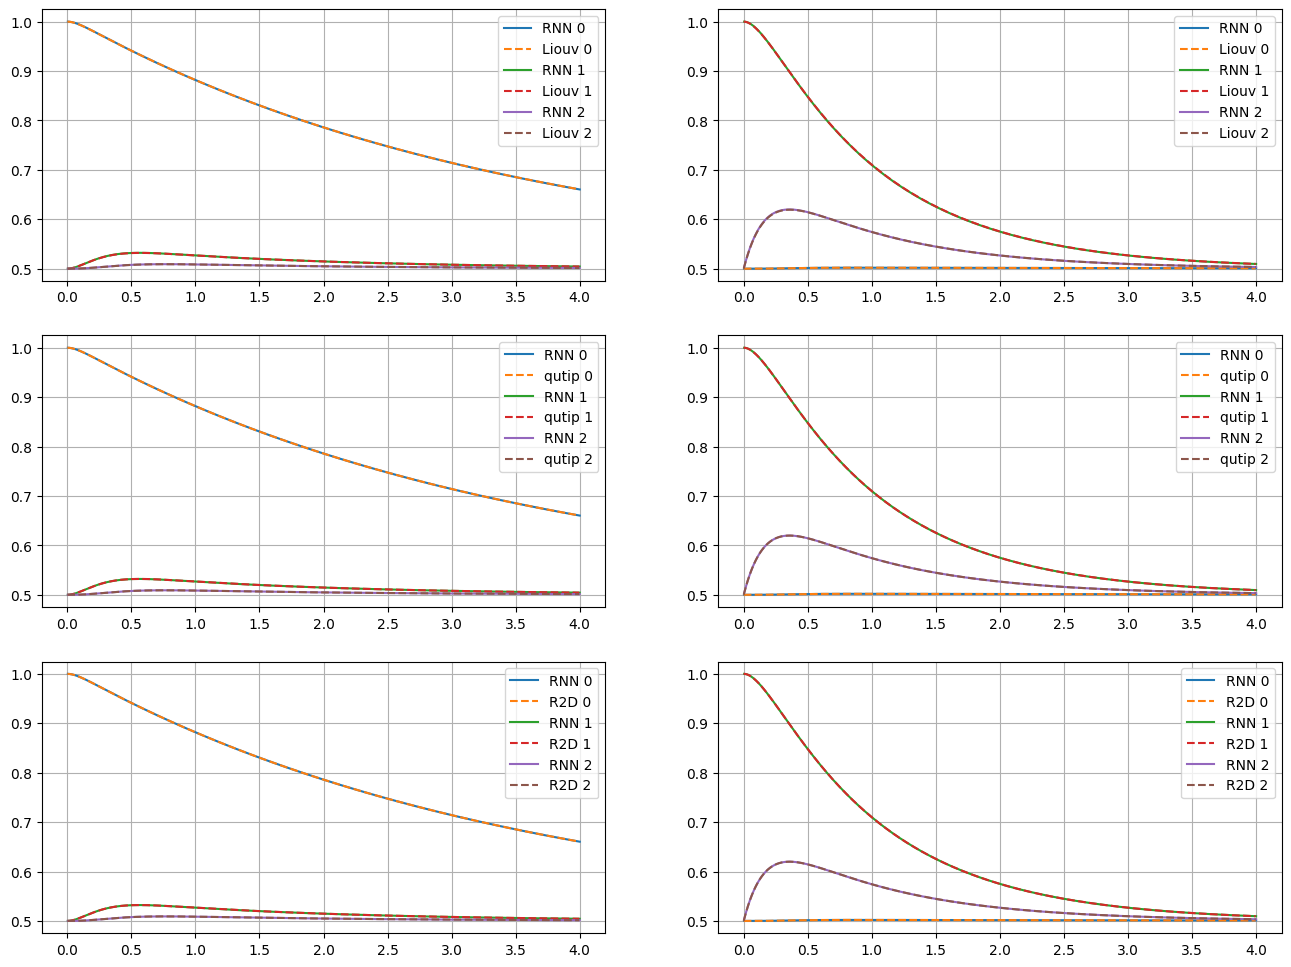

In [12]:
plt.figure(figsize=(16,12))
print('Liouv:')
for qidx in range(2):
  plt.subplot(3,2,qidx+1)
  for prob_idx in range(3):
    plt.plot(rnntvec, probs[paramidx, :, 2*prob_idx + qidx], label=f'RNN {prob_idx}')
    plt.plot(tvec, probs_truth[:,2*prob_idx + qidx], '--', label=f'Liouv {prob_idx}')
    print(2*prob_idx + qidx, tf.reduce_mean(tf.square(probs[paramidx, :-1, 2*prob_idx + qidx] - probs_truth[1:,2*prob_idx + qidx])))
  plt.legend()
  plt.grid();

print('\nQuTip:')
for qidx in range(2):
  plt.subplot(3,2,2+qidx+1)
  for prob_idx in range(3):
    plt.plot(rnntvec, probs[paramidx, :, 2*prob_idx + qidx], label=f'RNN {prob_idx}')
    plt.plot(tvec, 0.5*(result.expect[2*prob_idx+qidx] + 1.0), '--', label=f'qutip {prob_idx}')
    print(2*prob_idx + qidx, tf.reduce_mean(tf.square(probs[paramidx, :-1, 2*prob_idx + qidx] - 0.5*(result.expect[2*prob_idx+qidx][1:] + 1.0))))
  plt.legend()
  plt.grid();

print('\nR2D:')
for qidx in range(2):
  plt.subplot(3,2,4+qidx+1)
  for prob_idx in range(3):
    plt.plot(rnntvec, probs[paramidx, :, 2*prob_idx + qidx], label=f'RNN {prob_idx}')
    plt.plot(tvec, r2d_probs[paramidx, :, 2*prob_idx + qidx], '--', label=f'R2D {prob_idx}')
    print(2*prob_idx + qidx, tf.reduce_mean(tf.square(probs[paramidx, :-1, 2*prob_idx + qidx] - r2d_probs[paramidx, 1:, 2*prob_idx + qidx])))
  plt.legend()
  plt.grid();

In [13]:
qtmses = np.zeros(len(result.expect))
for ii in range(len(result.expect)):
    print(ii, tf.reduce_mean(tf.square(probs_truth[1:,ii] - probs[paramidx,:-1,ii])))
    print(ii, tf.reduce_mean(tf.square(probs_truth[:,ii] - 0.5*(result.expect[ii] + 1.0))))
max_qtmse = np.max(qtmses)

0 tf.Tensor(7.602841466773767e-09, shape=(), dtype=float64)
0 tf.Tensor(7.597010108887475e-09, shape=(), dtype=float64)
1 tf.Tensor(1.7750644899649192e-11, shape=(), dtype=float64)
1 tf.Tensor(1.7734325469837233e-11, shape=(), dtype=float64)
2 tf.Tensor(4.118565933281195e-09, shape=(), dtype=float64)
2 tf.Tensor(4.114642471744699e-09, shape=(), dtype=float64)
3 tf.Tensor(7.531283794253223e-08, shape=(), dtype=float64)
3 tf.Tensor(7.524437909834207e-08, shape=(), dtype=float64)
4 tf.Tensor(3.95376267313447e-10, shape=(), dtype=float64)
4 tf.Tensor(3.9500498385065147e-10, shape=(), dtype=float64)
5 tf.Tensor(5.442710802782925e-08, shape=(), dtype=float64)
5 tf.Tensor(5.4374670678294855e-08, shape=(), dtype=float64)


In [14]:
probs_truth[:10,0]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([1.        , 0.999985  , 0.99994103, 0.99986956, 0.99977199,
       0.99964966, 0.99950385, 0.99933578, 0.99914658, 0.99893738])>

In [15]:
0.5*(result.expect[0][:10] + 1.0)

array([1.        , 1.        , 0.99996948, 0.99991003, 0.99982316,
       0.9997103 , 0.99957283, 0.99941203, 0.99922914, 0.99902535])

In [16]:
probs[paramidx,:10,0]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([1.        , 0.99996948, 0.99991003, 0.99982316, 0.9997103 ,
       0.99957283, 0.99941203, 0.99922914, 0.99902535, 0.99880177])>

## Second Order Probabilities

tf.Tensor(1.0000000000000004, shape=(), dtype=float64)
tf.Tensor(1.0000000000000004, shape=(), dtype=float64)
tf.Tensor(1.0000000000000004, shape=(), dtype=float64)


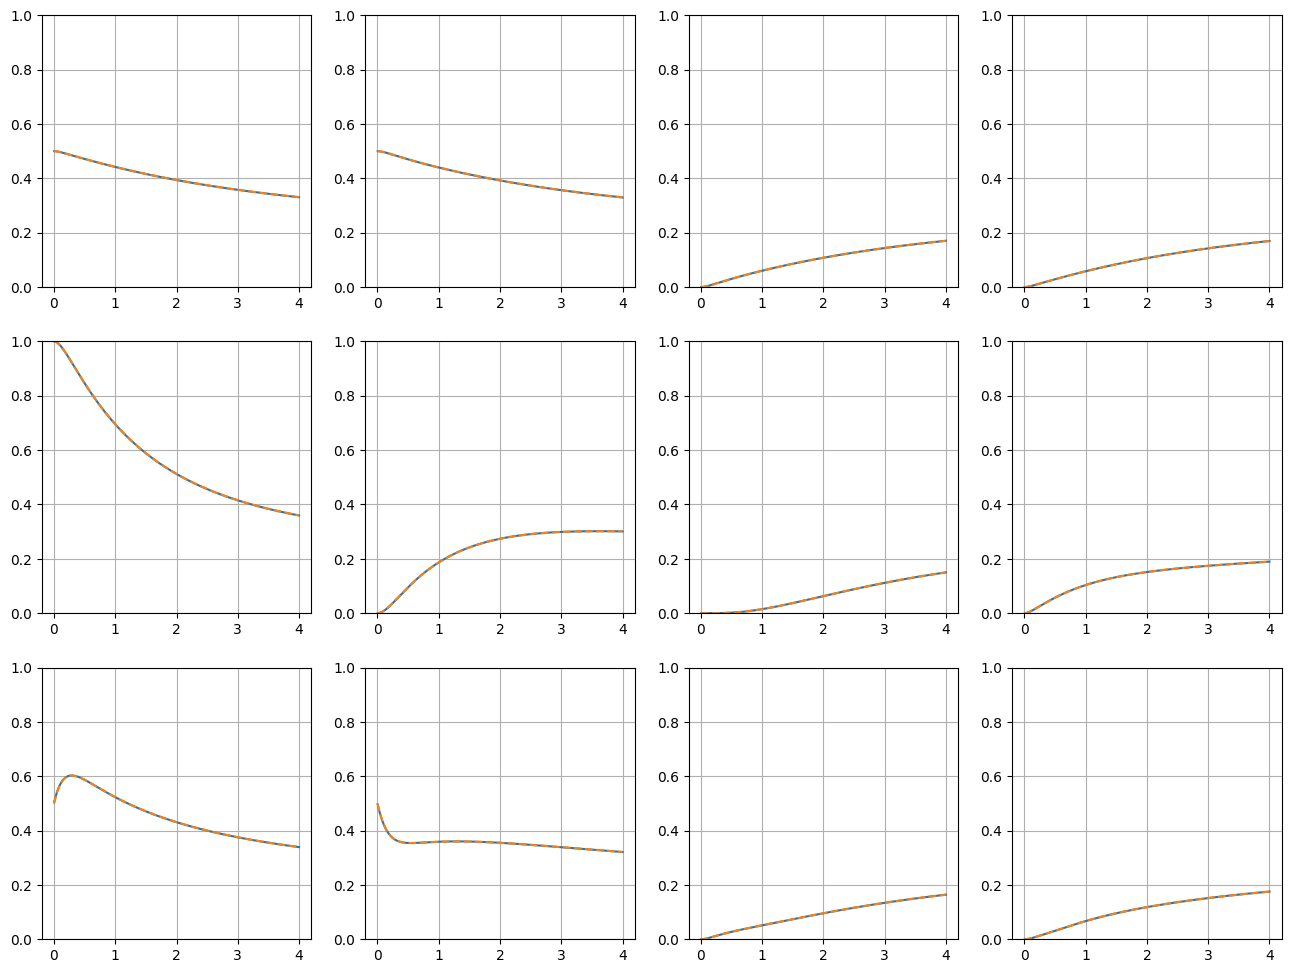

In [17]:
plt.figure(figsize=(16,12))
pltidx = 0
for rowidx in range(3):
  sum = 0.0
  for colidx in range(4):
    plt.subplot(3,4,pltidx+1)
    plt.plot(rnntvec, probs[paramidx,:,6+pltidx])
    sum += probs[paramidx,-1,6+pltidx]
    plt.plot(tvec, probs_truth[:,6+pltidx], '--')
    plt.grid();
    plt.ylim([0,1])
    pltidx += 1
  print(sum)

tf.Tensor(1.0000000000000004, shape=(), dtype=float64)
tf.Tensor(1.0000000000000004, shape=(), dtype=float64)
tf.Tensor(1.0000000000000004, shape=(), dtype=float64)


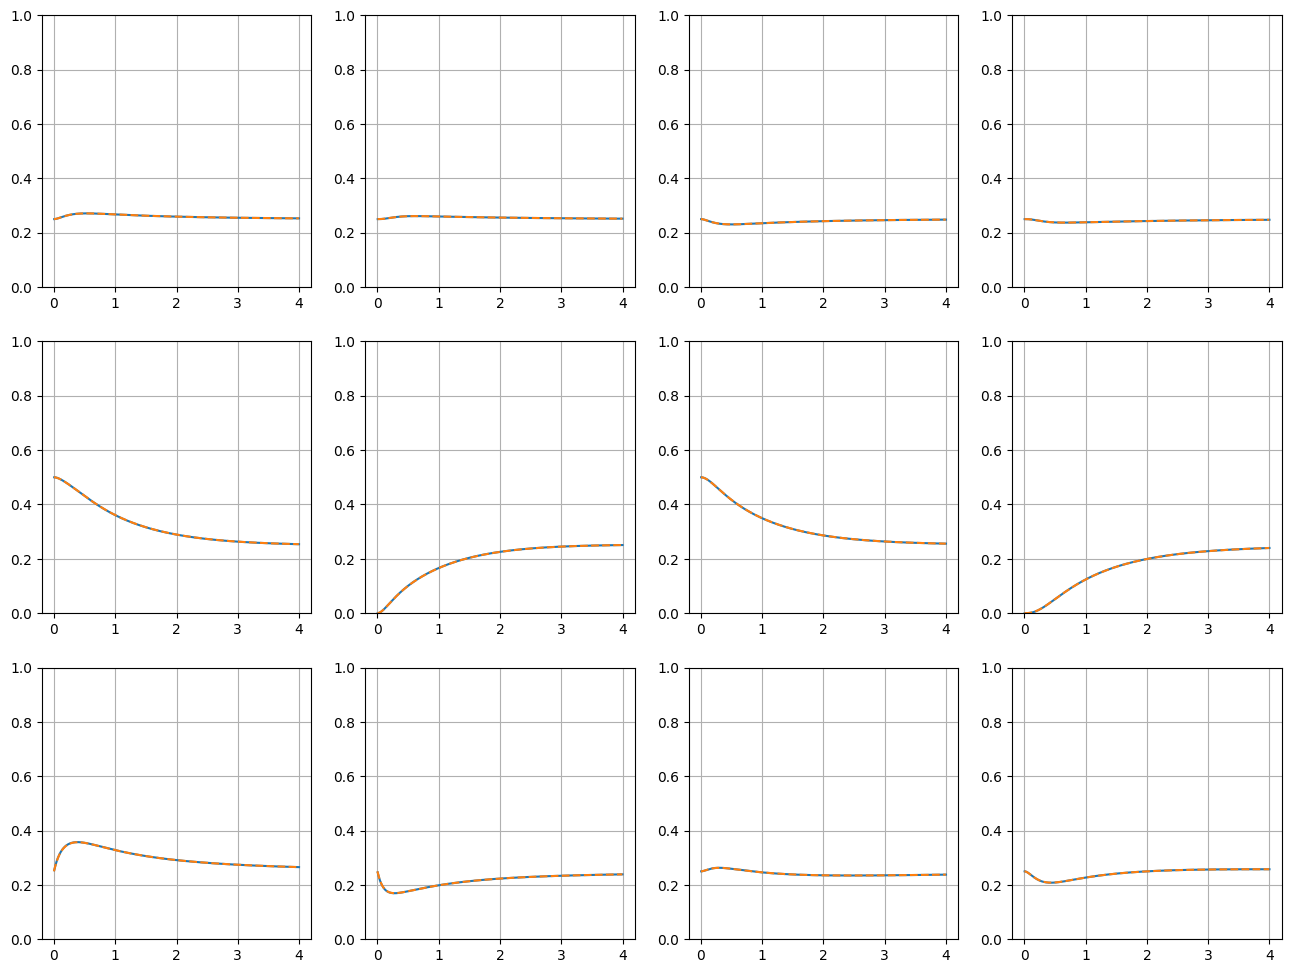

In [18]:
plt.figure(figsize=(16,12))
pltidx = 0
for rowidx in range(3):
  sum = 0.0
  for colidx in range(4):
    plt.subplot(3,4,pltidx+1)
    plt.plot(rnntvec, probs[paramidx,:,6+12+pltidx])
    sum += probs[paramidx,-1,6+12+pltidx]
    plt.plot(tvec, probs_truth[:,6+12+pltidx], '--')
    plt.grid();
    plt.ylim([0,1])
    pltidx += 1
  print(sum)

tf.Tensor(1.0000000000000004, shape=(), dtype=float64)
tf.Tensor(1.0000000000000004, shape=(), dtype=float64)
tf.Tensor(1.0000000000000007, shape=(), dtype=float64)


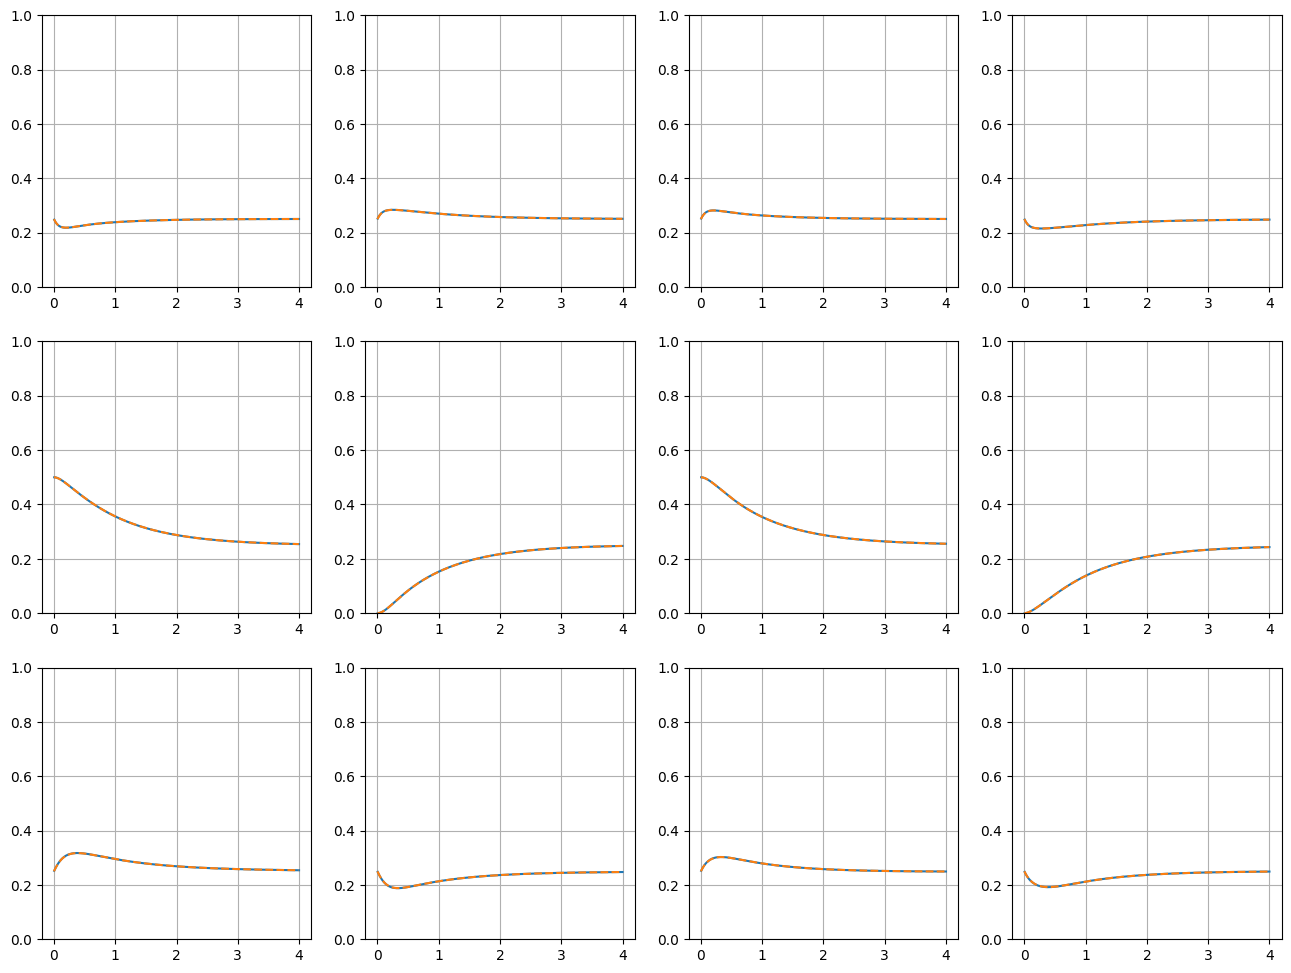

In [19]:
plt.figure(figsize=(16,12))
pltidx = 0
for rowidx in range(3):
  sum = 0.0
  for colidx in range(4):
    plt.subplot(3,4,pltidx+1)
    plt.plot(rnntvec, probs[paramidx,:,6+12+12+pltidx])
    sum += probs[paramidx,-1,6+12+12+pltidx]
    plt.plot(tvec, probs_truth[:,6+12+12+pltidx], '--')
    plt.grid();
    plt.ylim([0,1])
    pltidx += 1
  print(sum)

In [20]:
print(tf.reduce_min(probs[:,:,:42]), tf.reduce_max(probs[:,:,:42]))

tf.Tensor(-5.551115123125783e-16, shape=(), dtype=float64) tf.Tensor(1.0000000000000007, shape=(), dtype=float64)


In [21]:
import datetime
print(datetime.datetime.now())

2024-10-15 16:30:03.395348
